https://github.com/ibm-granite/granite-tsfm/blob/main/notebooks/hfdemo/ttm_getting_started.ipynb

In [44]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

from tsfm_public import (
    TimeSeriesForecastingPipeline,
    TimeSeriesPreprocessor,
    TinyTimeMixerForPrediction,
)
from tsfm_public.toolkit.time_series_preprocessor import prepare_data_splits
from tsfm_public.toolkit.visualization import plot_predictions

In [45]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
SEED = 42
timestamp_column = "time"
target_columns = "total load actual"

CONTEXT_LENGTH = 512
PREDICTION_LENGTH = 96


In [47]:
DATA = "hf://datasets/vitaliy-sharandin/energy-consumption-hourly-spain/energy_dataset.csv"


In [48]:
data = pd.read_csv(DATA, parse_dates=["time"])


# zero-shot

In [50]:
split=int(0.8 * len(data))
date_limit = data['time'].iloc[split]
train = data[data['time'] < date_limit]
test = data[data['time'] >= date_limit]

print(f"train = {len(train)}, test = {len(test)}")


train = 28051, test = 7013


In [60]:
column_specifiers = {
    "timestamp_column": timestamp_column,
    "id_columns": [],
    "target_columns": [target_columns],
    "control_columns": [],
}

In [61]:
column_specifiers

{'timestamp_column': 'time',
 'id_columns': [],
 'target_columns': ['total load actual'],
 'control_columns': []}

In [63]:
tsp_zero = TimeSeriesPreprocessor(
    **column_specifiers,
    context_length=CONTEXT_LENGTH,
    prediction_length=PREDICTION_LENGTH,
    scaling=True,
    scaler_type="standard",
)
tsp_zero.train(train)

TimeSeriesPreprocessor {
  "categorical_columns": [],
  "categorical_encoder": null,
  "conditional_columns": [],
  "context_length": 512,
  "control_columns": [],
  "encode_categorical": true,
  "feature_extractor_type": "TimeSeriesPreprocessor",
  "freq": "0 days 01:00:00",
  "frequency_mapping": {
    "10min": 4,
    "15min": 5,
    "2min": 2,
    "30min": 6,
    "5min": 3,
    "D": 8,
    "H": 7,
    "W": 9,
    "d": 8,
    "h": 7,
    "min": 1,
    "oov": 0
  },
  "id_columns": [],
  "observable_columns": [],
  "prediction_length": 96,
  "processor_class": "TimeSeriesPreprocessor",
  "scale_categorical_columns": true,
  "scaler_dict": {},
  "scaler_type": "standard",
  "scaling": true,
  "scaling_id_columns": [],
  "static_categorical_columns": [],
  "target_columns": [
    "total load actual"
  ],
  "target_scaler_dict": {
    "0": {
      "copy": true,
      "feature_names_in_": [
        "total load actual"
      ],
      "mean_": [
        28656.06617410858
      ],
      "n_f

In [ ]:
# Instantiate the model.
zeroshot_model = TinyTimeMixerForPrediction.from_pretrained(
    "ibm-granite/granite-timeseries-ttm-r2", 
    revision="512-96-ft-r2.1",
    num_input_channels=len(target_columns),  
)


In [ ]:
pipeline = TimeSeriesForecastingPipeline(
    zeroshot_model,
    feature_extractor=tsp_zero,
    batch_size=512,
)

Device set to use cpu


In [ ]:
zeroshot_forecast = pipeline(test)
zeroshot_forecast.head()


,time,total load actual_prediction,total load actual
0,2018-04-05 03:00:00+02:00,"[22520.514475504297, 22717.981199951344, 23629...","[22842.999905548208, 23301.00002072889, 25546...."
1,2018-04-05 04:00:00+02:00,"[22782.19476161051, 23674.994561974327, 25524....","[23301.00002072889, 25546.999903705666, 28409...."
2,2018-04-05 05:00:00+02:00,"[23888.378356534966, 25470.302574604044, 27708...","[25546.999903705666, 28409.999997526807, 30639..."
3,2018-04-05 06:00:00+02:00,"[26354.629459797612, 28279.688488741016, 30493...","[28409.999997526807, 30639.000007435854, 31795..."
4,2018-04-05 07:00:00+02:00,"[29316.716740174703, 31229.055116097086, 32608...","[30639.000007435854, 31795.000126792984, 32204..."


In [ ]:


def custom_metric(actual, prediction, column_header="results"):
    """Simple function to compute MSE"""
    a = np.asarray(actual.tolist())
    p = np.asarray(prediction.tolist())

    mask = ~np.any(np.isnan(a), axis=1)

    mse = np.mean(np.square(a[mask, :] - p[mask, :]))
    mae = np.mean(np.abs(a[mask, :] - p[mask, :]))
    return pd.DataFrame(
        {
            column_header: {
                "mean_squared_error": mse,
                "root_mean_squared_error": np.sqrt(mse),
                "mean_absolute_error": mae,
            }
        }
    )

custom_metric(
    zeroshot_forecast["total load actual"], zeroshot_forecast["total load actual_prediction"], "zero-shot forecast"
)



,zero-shot forecast
mean_squared_error,8.568889e+06
root_mean_squared_error,2.927267e+03
mean_absolute_error,2.213314e+03


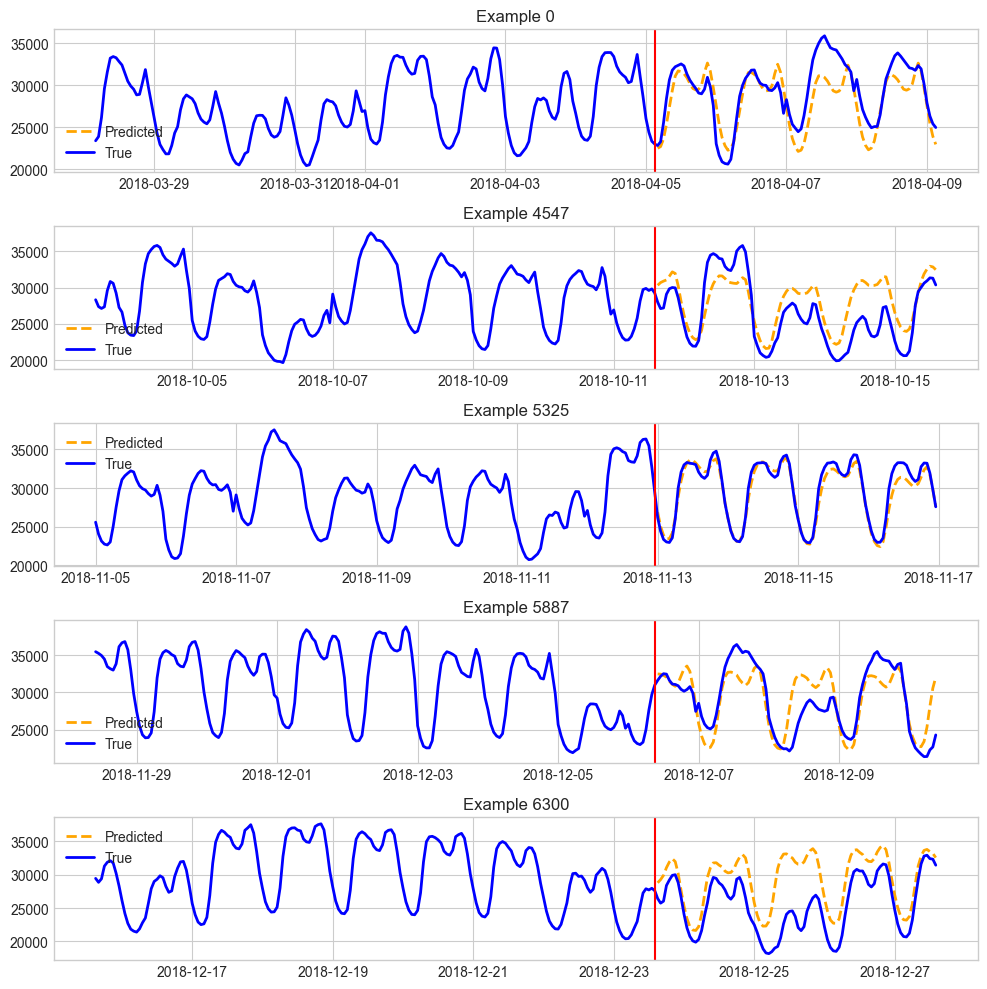

In [72]:
# plot
plot_predictions(
    input_df=test,
    predictions_df=zeroshot_forecast,
    freq="h",
    timestamp_column=timestamp_column,
    channel=target_columns,
    indices=[0, 4547, 5325, 5887, 6300],
)